_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os
import tensorflow as tf
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Deep neural networks have more than one hidden layes. As we add more layers, we may face several problems:
    1. Vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train.
    2. Slow Training
    3. Risk overfitting the training set
  We will look at these problem and try to solve them.

# Vanishing/Exploding Gradients Problem

Backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. <br>

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. <br>

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which is mostly encountered in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds. <br>

This problem was largely unresolved until 2010 A paper titled “Understanding the Difficulty of Training
Deep Feedforward Neural Networks” by Xavier Glorot and Yoshua Bengi found that random weight initialization using a normal distribution with a mean of 0 and a standard deviation of 1 fixes the problem. If this is not done, the variance is increases with each additional layer. <br>

This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks). <br>

In Logistic activation function inputs may become large (negative or positive) and the function saturates at 0 or 1, with a derivative extremely close to 0. When backpropagation starts, it has little gradient to propagate back through the network, and this small gradient keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers. <br>

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


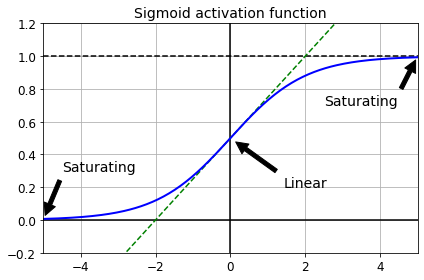

In [5]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

The signal need to signal to flow properly in both directions: in the forward direction when making predictions, and in the
reverse direction when backpropagating gradients without dying or saturation. <br>

The proposed solution by Glorot and Bengio requires equal variance in inputs and outputs. It is actually not possible unless the layer has an equal number of input and output connections. But there is a good compromise: <br>

The connection weights must be initialized randomly according to the following formula (He or Glorot initialization) of logistic activation function. <br>

He for ReLU
Normal distribution with mean 0 and standard deviation $\sigma=\sqrt{\frac{2}{n_{inputs} + n_{outputs}}}$ <br>

For uniform distribution $U(-r,r)$ with $r=\sqrt{\frac{6}{n_{inputs} + n_{outputs}}}$ <br>

When the number of of connections is equal it can be simplified to $\sigma = \sqrt{\frac{1}{n_{inputs}}}$

For None, tanh, logistic, softmax -- Glorot initialization

$fan_{in} = N_{inputs} + N_{neurons}$ <br>$fan_{out} = N_{outputs} + N_{neurons}$ <br>$fan_{avg} = (fan_{in} + fan_{out})/2$ <br>
The connection weights must be initialized randomly according to the following formula (Glorot initialization) of logistic activation function. <br>
Normal distribution with mean 0 and standard deviation $\sigma=\sqrt{\frac{1}{fan_{avg}}}$ <br>
For uniform distribution $U(-r,r)$ with $r=\sqrt{\frac{3}{fan_{avg}}}$ <br>
When the number of of connections is equal it can be simplified to $\sigma = \sqrt{\frac{1}{fan_{avg}}}$.




In [6]:
import tensorflow as tf
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [7]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

We use *fan_avg* for Glorot initialization.

In [8]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

Glorot and Bengio show that the vanishing/exploding gradients problems were in part due to a poor choice of activation function. Sigmoid function copied from biology is not a good choice. ReLU activation function performs much better, mostly it does not produce extreme values and is fast to compute. <br>


ReLU wiht large learning rate suffers from a problem known as the dying neurons when they stop outputting anything other than 0. If the updated weights produce $z<0$ the ReLU function will return 0 and the gradiend will be also 0. This neuron is likely to stay dead. <br>

There a few ways to solve this problem: <br>

1. Leaky ReLU defined as $LeakyReLU \alpha(z) = \max(\alpha z, z)$. The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for z < 0, and is typically set to 0.01.  This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. Leaky ReLU tends to outperfrom ReLU activation function. Large $\alpha=0.2$ sometimes performs better than 0.01. 

2. Randomized Leaky ReLU (RReLU), where $\alpha$ is picked randomly during training and fixed during testing. This randomization reduces overfitting.

3. Parametric Leaky ReLU (PReLU) where we optimeze parameter $\alpha$ during backpropagation. This methods overperforms other ReLU on large datasets, but tends to overfit smaller ones. 

Keras activation funcitons

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
# Relue activation functions:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### Leaky ReLU

Djork-Arné Clevert et al. the exponential linear unit (ELU) activation function, it tends to outperform other ReLU both in time and testing accuracy:
$$ELU_{\alpha}(z) = \begin{cases} \alpha(\exp(z) -1) \quad &if \quad z<0 \\ z \quad &if \quad z \geq 0 \end{cases}$$

It looks a lot like the ReLU function, with a few major differences:
1. It take negative values when z < 0, which allows the unit to have an average output closer to 0 helping to alleviate vanishing gradients problem.
2. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can be tweaked.
3. ELU has a nonzero gradient for $z < 0$, which avoids the dying units issue.
4. ELU is is smooth everywhere, including around z = 0, which helps speed up Gradient Descent. <br>


The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its
variants (due to the use of the exponential function), but during training this is compensated by the faster
convergence rate. However, at test time an ELU network will be slower than a ReLU network.

In [11]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


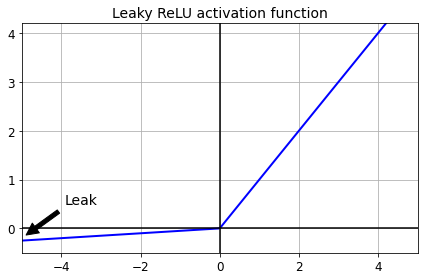

In [12]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in Keras:

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]



In [14]:
# LeakyRelu model
tf.random.set_seed(42)
np.random.seed(42)
# build the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])
# compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
# Run the model:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 992us/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 902us/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 2s 930us/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 928us/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 1s 851us/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 890us/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - v

### ELU

Djork-Arné Clevert et al. the exponential linear unit (ELU) activation function, it tends to outperform other ReLU both in time and testing accuracy:
$$ELU_{\alpha}(z) = \begin{cases} \alpha(\exp(z) -1) \quad &if \quad z<0 \\ z \quad &if \quad z \geq 0 \end{cases}$$

It looks a lot like the ReLU function, with a few major differences:
1. It take negative values when z < 0, which allows the unit to have an average output closer to 0 helping to alleviate vanishing gradients problem.
2. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can be tweaked.
3. ELU has a nonzero gradient for $z < 0$, which avoids the dying units issue.
4. ELU is is smooth everywhere, including around z = 0, which helps speed up Gradient Descent. <br>


The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its
variants (due to the use of the exponential function), but during training this is compensated by the faster
convergence rate. However, at test time an ELU network will be slower than a ReLU network.

In [15]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


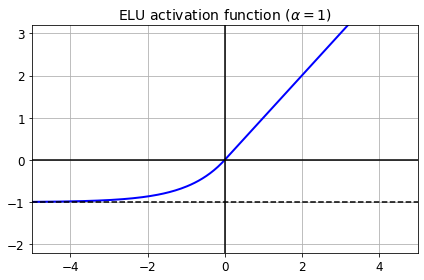

In [16]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [17]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.



 During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: <br>

The output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.
$$selu(x)=\lambda \begin{cases} \alpha\exp(z) - \alpha \quad &if \quad z<0 \\ x \quad &if \quad z \geq 0 \end{cases}$$
We solve for $\alpha$ and $\lambda$ to find a fixed point that preserves mean and variance from layer to layer:
$$g(\mu, v, \alpha, \lambda) = (\mu, v)$$
Gradients neigher explode nor vanish. 




In [18]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [19]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


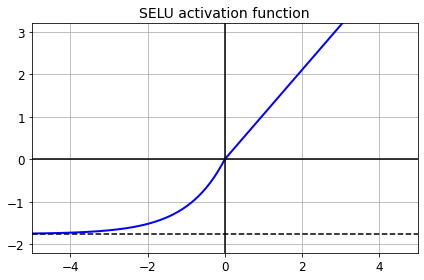

In [20]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1.
Requirements: <br>
- The input features must be standardized (mean 0 and standard deviation 1).
- Every hidden layer’s weights must be initialized with LeCun normal initialization.
In Keras, this means setting kernel_initializer="lecun_normal".
- The network’s architecture must be sequential. It will not work in 
in nonsequential architectures, such as recurrent networks, networks with skip connections (i.e., connections that skip layers, such
as in Wide & Deep nets). 
-SELU will not necessarily outperform other activation functions.

Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [21]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [22]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
# constiruct 100 layer model to guarntee overfitting
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [25]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [26]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0538 - accuracy: 0.5901 - val_loss: 0.7711 - val_accuracy: 0.6858
Epoch 2/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7687 - accuracy: 0.7254 - val_loss: 0.7534 - val_accuracy: 0.7384
Epoch 3/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6835 - accuracy: 0.7554 - val_loss: 0.5943 - val_accuracy: 0.7834
Epoch 4/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5744 - accuracy: 0.7911 - val_loss: 0.5434 - val_accuracy: 0.8066
Epoch 5/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5406 - accuracy: 0.8114 - val_loss: 0.4907 - val_accuracy: 0.8218


Did not work. 
Now look at what happens if we try to use the ReLU activation function instead:

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [31]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.7806 - accuracy: 0.2781 - val_loss: 1.5971 - val_accuracy: 0.3048
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.1593 - accuracy: 0.5055 - val_loss: 0.9156 - val_accuracy: 0.6372
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8950 - accuracy: 0.6358 - val_loss: 0.8928 - val_accuracy: 0.6246
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7905 - accuracy: 0.6851 - val_loss: 0.6914 - val_accuracy: 0.7396
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7051 - accuracy: 0.7287 - val_loss: 0.6638 - val_accuracy: 0.7380


How to choose activation function:

1. ReLU is a good fast default for first estimation. Many packages have ReLU default and are optimized for it's use. Leaky ReLU is also quite fast. 
2. In general quality is ranked by SELU>ELU>Leaky ReLU, > ReLU, tanh > logistics. 

# Batch Normalization

He intialization and ELU can reduce the danger of vanishing/exploding gradients at the beginning of training the problem may arise later in the training process. 

Batch Normalization zero-centers and normilizes the data before each layer. So each layer has two new parameters for centering (mean) and scaling (standard deviation). 

In many case if you add BN before the first layer you may not need to scale your data. 

BN algorithm:

1. $\mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B}x^{(i)}$
2. $\sigma_B = \frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}- \mu_B)^2$
3. $\hat{x}^{(i)} = \frac{x^{(i)} - \mu_{B}}{\sqrt{\sigma_{B}^2 + \epsilon}}$
4. $z^{(i)} = \gamma \otimes \hat{x}^{(i)} + \beta$


$\mu_B$, $\sigma_B$ is the vector of output means and standard deviations evaluated for each batch. $m_B$ is the number of instances in a batch and $\hat{x}^{(i)}$ is the vectors of normilized inputs for instance $i$. 

* $\gamma$ s the output scale parameter vector for the layer
* $\otimes$ represents element-wise multiplication
* $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.
* $\epsilon$ is a tiny number that avoids division by zero (typically 10–5). This is called a smoothing term.
* $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the
inputs.

The BatchNormalization usese moving average to normilized data inside network.

Four parameter vectors are learned in each batch-normalized layer: γ (the output scale vector) and β (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and σ (the final input standard deviation vector) are estimated using an exponential moving average.

Note that μ and σ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations.

Batch normalization significantly improve prediction in ImageNet classification problems (Ioffe and Szegedy) it also eliminates the need for other regularization (LASSO, RIDGE, etc). 


Batch Normilization slows down the model estimation, although it makes the convergence faster, often reducing the total time for model estimation. 

If a regular NN model estimates $XW + b$ in each layer, the BN+NN model estimates $\gamma \otimes (XW +b - \mu)/\sigma + \beta$.

In Keras you can just add `BatchNormalization` layer before and after each hidden layer. For example:

In [32]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In a small model with few layers `BatchNormalization` may not have a large impact.

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_209 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_210 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_211 (Dense)            (None, 10)               

First layer of BN adds 3,136 parameters. $\mu$ and $\sigma$ are just moving averages and they are not affected by back-propagations, so Keras calls them non-trainable. In total BN adds 4,736 parameters out which 2,368 are "non-trainable".

In [34]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [36]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5526 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4725 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5189 - accuracy: 0.8203 - val_loss: 0.4375 - val_accuracy: 0.8558
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4827 - accuracy: 0.8322 - val_loss: 0.4153 - val_accuracy: 0.8596
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3997 - val_accuracy: 0.8640
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4398 - accuracy: 0.8475 - val_loss: 0.3867 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4241 - accuracy: 0.8513 - val_loss: 0.3763 - val_accuracy:

In our example, the save time was negligible. Though we reached a bit higher validation accuracy the convergence speeed decreased (accuracy growth was slower).

Batch normalization has a lot of parameters to optimize, see pages 343-344 for more details. 

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called transfer learning.

It will not only speed up training considerably, but will also require much less training data.

For example, suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, so you should try to reuse parts of the first network. 

![Neuron inner working g](images/Figure_11_4.png)

Recycling lower levels is the most useful because the break picture into segements that can be undetstood by a machine learning, and coarse classification. Upper level are more task-specific and they need to be estimated.

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [40]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))
# split data into training, validation and testing
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
# get small training data to simulate low-resource model
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [41]:
X_train_A.shape

(43986, 28, 28)

In [42]:
# small trianing
X_train_B.shape

(200, 28, 28)

In [43]:
# Full training
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [44]:
# Sandals or shirts?
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

In [46]:
# Main model specification 5 layers, like in the picture.
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [47]:
# model construciton
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [48]:
# train Task A
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 1s 983us/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.3171 - accuracy: 0.8895 - val_loss: 0.3013 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 1s 972us/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2896 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2773 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2730 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.2642 - accuracy: 0.9093 - val_loss: 0.2721 - val_accur

In [49]:
# save model
model_A.save("my_model_A.h5")

In [50]:
# Model B has the same architecture as A
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [51]:
# Compile model B
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [52]:
# Estimate Model B without recycling
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 25ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [53]:
# Final validation accuracy 0.9767
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [54]:
# Load model A
model_A = keras.models.load_model("my_model_A.h5")
# Recycle all layers except the last one 
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# Add 1 layer to the recycled layer
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [55]:
# clone model A’s architecture with

model_A_clone = keras.models.clone_model(model_A)
#copy its weights (since clone_model() does not clone the weights)
model_A_clone.set_weights(model_A.get_weights())

In [56]:
# We will freeze the weight for the first few epochs in the recycled layers so the top layer can adjust to recycled weights and data. 
#If don't freeze them the gradients may become unstable.
for layer in model_B_on_A.layers[:-1]:
  # stop training the recycled layer
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Train for 4 epochs with 4 frozen layers
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
# Next 16 epochs unfreeze the recycle layers
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 23ms/step - loss: 0.5802 - accuracy: 0.6500 - val_loss: 0.5843 - val_accuracy: 0.6329
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.6800 - val_loss: 0.5467 - val_accuracy: 0.6805
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.5068 - accuracy: 0.7250 - val_loss: 0.5146 - val_accuracy: 0.7089
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 0.4752 - accuracy: 0.7500 - val_loss: 0.4859 - val_accuracy: 0.7323
Epoch 1/16
7/7 [==============================] - 0s 23ms/step - loss: 0.3965 - accuracy: 0.8150 - val_loss: 0.3460 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 7ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2603 - val_accuracy: 0.9310
Epoch 3/16
7/7 [==============================] - 0s 7ms/step - loss: 0.2085 - accuracy: 0.9650 - val_loss: 0.2110 - val_accuracy: 0.9554
Epoch 4/16
7/7 [====================

So, what's the final verdict?

In [58]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 823us/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [59]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 836us/step - loss: 0.0682 - accuracy: 0.9935


[0.0681881457567215, 0.9934999942779541]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [60]:
(100 - 97.05) / (100 - 99.30)

4.214285714285701

It looks more impressive then it really is. "I cheated! I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses.”"

Whenever you see too impressive results, probably someone estimates 1000 models and is showing the best under some convinient justification. This is not nessarily wrong but is a major impediment in science replication.

Recycling of layers works best with deep networks and esspecially with Convulutions Neural Networks, which we will study later.



# Tweaking, Dropping, or Replacing the Upper Layers

1. The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.
2. the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task.
3. Try freezing all the copied layers first, then train your model and see how it performs.
4. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze.
5. If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freeze all remaining hidden layers again.
6. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

# Model Zoos
Where can you find a neural network trained for a task similar to the one you want to tackle? The first place to look is obviously in your own catalog of models. This is one good reason to save all your models and organize them so you can retrieve them later easily. Another option is to search in a model zoo. Many people train Machine Learning models for various tasks and kindly release their pretrained models to the public.

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training:

1. applying a good initialization strategy for the connection weights
2. using a good activation function
3. using Batch Normalization/SELU
4. reusing parts of a pretrained network. 

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.


Momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.
 
Adam optimization is usally the best. 

## Momentum optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance).

In contrast, regular Gradient Descent will simply take small regular steps down the slope, so it will take much more time to reach the bottom.

Gradient Descent simply updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regards to the weights $(\nabla\theta J(\theta))$multiplied by the learning rate $\eta$. The equation is: $\theta=\theta - \eta \nabla_{\theta} \theta J(\theta)$. 

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.


Momentum optimization cares a great deal about what previous gradients were: at each iteration, it adds the local gradient to the momentum vector $m$ (multiplied by the learning rate $\eta$), and it updates the weights by simply subtracting this momentum vector.

In other words, the gradient is used as an acceleration, not as a speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, simply called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

$$m = \beta m + \eta \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - m$$

If the gradient remains constant then the maximum size of weight updates is
$$m(1-\beta)= \eta \nabla_{\theta} \theta J(\theta)$$
For $\beta = 0.9$, we reach terminal velocity when $m = 10 * \eta \nabla_{\theta} \theta J(\theta)$. It means that momentum optimization will be 10 times faster than the gradient descent. Momentum is especially fast when dealing with flat-gradients and it helps not to get stuck in the local optima.

In [61]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

Modification of Momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla Momentum optimization.

The idea of Nesterov Momentum optimization, or Nesterov Accelerated Gradient (NAG) measures the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at $\theta + \beta m$ rather than at $\theta$.

$$m = \beta m - \eta \nabla_{\theta} \theta J(\theta + \beta m)$$
$$\theta = \theta + m$$

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position,


$\nabla_1$ is the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ is the gradient at the point located at $\theta + \beta m$). 

The Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular Momentum optimization. 

Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push further across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus converges faster.

![Neuron inner working g](images/Lesson10/image2.png)

In [62]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. 

It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum. The AdaGrad algorithm achieves this by scaling down the gradient vector along the steepest dimensions:

$$s=s + \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - \eta \nabla_{\theta} \theta J(\theta) \oslash \sqrt{s + \epsilon}$$

The first step accumulates the square of the gradients into the vector $s$ (the $\otimes$  symbol represents the element-wise multiplication). 

This vectorized form is equivalent to computing $s_i = s_i + (\partial/\partial \theta_i J(\theta))^2$ for each element $s_i$ of the vector $s$. 
Each $s_i$ accumulates the squares of the partial derivative of the cost function with regards to parameter $\theta_i$. If the cost function is steep along the ith dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector $s$ is scaled down by a factor of $\sqrt{s+\epsilon}$. $\oslash$ is the element-by-element division, and $\epsilon$ is the smoothing term to avoid division by zero set to $10^{-10}$. This is equivalent to element-wise:
$\theta_i = \theta_i - \eta \partial/\partial \theta_i J(\theta)/\sqrt{s+\epsilon}$


In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum  One additional benefit is that it requires much less tuning of the learning rate hyper-parameter $\eta$.



![Neuron inner working g](images/Lesson10/image3.png)

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though TensorFlow has an AdagradOptimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though).

In [63]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training).

It does so by using exponential decay in the first step:

$$s=\beta s + (1-\beta) \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - \eta \nabla_{\theta} \theta J(\theta) \oslash \sqrt{s + \epsilon}$$

In [64]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

Adam is Adaptive Moment Estimation, combines the ideas of Momentum optimization and RMSProp:
1.Like Momentum optimization it keeps track of an exponentially decaying average of past gradients (direction)
2.Like RMSProp it keeps track of an exponentially decaying average of past squared gradients (size)

1. $m = \beta_1 m + (1- \beta_1) \nabla_{\theta} J(\theta)$
2. $s= \beta_2 s + (1 - \beta_2) \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$
3. $m = \frac{m}{1-\beta_1^T}$
4. $s = \frac{s}{1-\beta_2^T}$
5. $\theta = \theta - \eta m \oslash \sqrt{s + \epsilon}$

Steps 1,2 and 5 are similar to Momentum optimization and RMSProp.

Steps 3 and 4 are technical: since $m$ and $s$ are initialized at 0, they will be biased toward $0$ at the beginning of training, so these two steps will help boost $m$ and $s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{–7}$. These are the default values for Keras AdamOptimizer class, so you can simply use:

In [65]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Nadam

Nadam optimization is Adam optimization plus the Nesterov trick, so it will
often converge slightly faster than Adam. 

While adaptive optimization works great on some datasets it performs poorly on others, so you need to try several ways in estimating your model (Ashia C. Wilson et al, 2017).

All the optimization algorithms discussed above are based on first-order partial
derivatives (Jacobians). While in theory second-order deriviatives (Hessian matrix) exists and are amazing, in the practice the number of second derivitatives is $n^2$ per output vs $n$ first deriviatives, which makes them impractical to use to for model with many parameters.


In [66]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)


![Neuron inner working g](images/Table_11_2.png)

## Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time.

If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle).

If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.


![Neuron inner working g](images/Lesson10/image4.png)

You can try running the model several time for optimal learning rate. But you can do better:

1. start with a high learning rate
2. reduce it once it stops making fast progress

These strategies are called learning schedules:
1. Predetermined piecewise constant learning rate: set the learning rate to $\eta_0 = 0.1$ at first, then to $\eta_1 = 0.001$ after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
2. Exponential scheduling. Set the learning rate to a function of the iteration number t: $\eta(t) = \eta_0 + 10^{-t/r}$ This works great, but it requires tuning $\eta_0$ and $r$. The learning rate will drop by a factor of 10 every $r$ steps.
3. Power scheduling. Set the learning rate to $\eta(t) = \eta_0 (1 + t/r)^{-c}$. The hyperparameter $c$ is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly.
4. Performance scheduling. Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.
5. 1cycle scheduling. 1cycle starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training. Then it decreases the learning rate linearly down to $\eta_1$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The estimation invovles a bit more complex programming, so I won't cover in a great details, but I will be happy to answer the quesitons.

The maximum learning rate $\eta_1$ is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate $\eta_1$ is chosen to be roughly 10 times lower. 

When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training
(e.g., down to 0.85, linearly), and then bring it back up to the maximum value
(e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Experiments showed that this approach
was often able to speed up training considerably and reach better performance.
For example, on the popular CIFAR10 image dataset, this approach reached
91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800
epochs through a standard approach (with the same neural network
architecture).

Testing showed that oth performance scheduling and exponential scheduling  performed the best, but power is easy and fast. 

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [67]:
# specialized decay power scheduling
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [68]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [69]:
# estimate baseline model
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4875 - accuracy: 0.8279 - val_loss: 0.4029 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3804 - accuracy: 0.8655 - val_loss: 0.3723 - val_accuracy: 0.8702
Epoch 3/25
1719/1719 [==============================] - 2s 995us/step - loss: 0.3484 - accuracy: 0.8769 - val_loss: 0.3750 - val_accuracy: 0.8680
Epoch 4/25
1719/1719 [==============================] - 2s 995us/step - loss: 0.3280 - accuracy: 0.8839 - val_loss: 0.3528 - val_accuracy: 0.8784
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3134 - accuracy: 0.8889 - val_loss: 0.3471 - val_accuracy: 0.8766
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2996 - accuracy: 0.8941 - val_loss: 0.3469 - val_accuracy: 0.8790
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2899 - accuracy: 0.8974 - val_loss: 0.3411 - val_accur

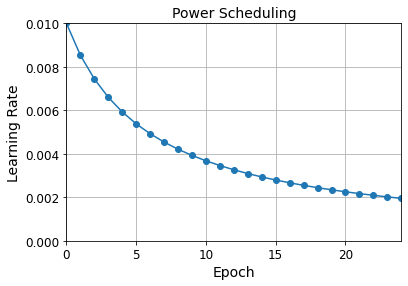

In [70]:
# initial learning rate
learning_rate = 0.01
# decay power
decay = 1e-4
# increase batch size to 32
batch_size = 32
# steps per epoch N/batch_size
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
# the learning rate function
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)
# Show a picture
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [71]:
# Define exponential decay as function of the epoch
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [72]:
# add starting value
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [73]:
# build a model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [74]:
# run the mode. Put user-define function through LearningRate scheduler
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8552 - accuracy: 0.7545 - val_loss: 0.8343 - val_accuracy: 0.7316
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7179 - accuracy: 0.7869 - val_loss: 0.6313 - val_accuracy: 0.8084
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6397 - accuracy: 0.8134 - val_loss: 0.7200 - val_accuracy: 0.7724
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5781 - accuracy: 0.8319 - val_loss: 0.5548 - val_accuracy: 0.8272
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5254 - accuracy: 0.8423 - val_loss: 0.5734 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4546 - accuracy: 0.8605 - val_loss: 0.5911 - val_accuracy: 0.8616
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4376 - accuracy: 0.8655 - val_loss: 0.5290 - val_accuracy:

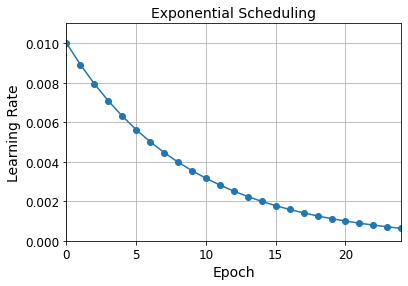

In [75]:
# The decrease is much sharper than in the case of Power scheduling
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

### Piecewise Constant Scheduling

In [76]:
# define changes to the learning rate
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [77]:
# function is designed for 3 piecewise schedules
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [78]:
# insert user-defined function
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8450 - accuracy: 0.7580 - val_loss: 0.8775 - val_accuracy: 0.7430
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8240 - accuracy: 0.7643 - val_loss: 1.0066 - val_accuracy: 0.7138
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8003 - accuracy: 0.7711 - val_loss: 1.9246 - val_accuracy: 0.6668
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9649 - accuracy: 0.7050 - val_loss: 0.8715 - val_accuracy: 0.7570
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8858 - accuracy: 0.7151 - val_loss: 1.1756 - val_accuracy: 0.5628
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8425 - accuracy: 0.6789 - val_loss: 0.6874 - val_accuracy: 0.7276
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5994 - accuracy: 0.8062 - val_loss: 0.6197 - val_accuracy:

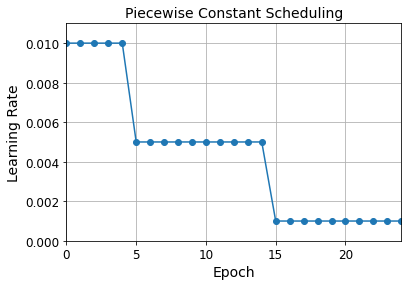

In [79]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [80]:
tf.random.set_seed(42)
np.random.seed(42)

In [81]:
# We internal ReduceLROnPlateau function, which reduces learning rate by 0.5 is if it not improving for 5 iterations. 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5917 - accuracy: 0.8073 - val_loss: 0.4869 - val_accuracy: 0.8478
Epoch 2/25
1719/1719 [==============================] - 2s 962us/step - loss: 0.4973 - accuracy: 0.8394 - val_loss: 0.5958 - val_accuracy: 0.8270
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5334 - accuracy: 0.8373 - val_loss: 0.4869 - val_accuracy: 0.8584
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5156 - accuracy: 0.8466 - val_loss: 0.4588 - val_accuracy: 0.8548
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5144 - accuracy: 0.8512 - val_loss: 0.6096 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5111 - accuracy: 0.8541 - val_loss: 0.5359 - val_accuracy: 0.8498
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5334 - accuracy: 0.8531 - val_loss: 0.5457 - val_accurac

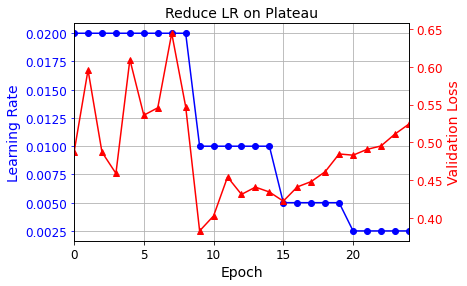

In [82]:
# LR on PLateau is a quicker, but less stablele learning. It reached optimimum by epoch 15 when overfitting started.
# It also offered the fastest learning 6-7 seconds per epoch in the beginning.
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')
          
plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

This is the fastest method so far. The code is slightly more complicated because it uses class: funciton of functions.

In [83]:
# call Keras
K = keras.backend
# this function saves in a vectors learning rates and losses and recalculates the new learning rate.
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
      # arguments to enter factor
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
      # get value of the current learning rate
        self.rates.append(K.get_value(self.model.optimizer.lr))
        # append the vector of losses
        self.losses.append(logs["loss"])
        # set new value by multiplay factor by the current loss
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


# specify max and min rates
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
  # initial model weights
    init_weights = model.get_weights()
    # number of iteractions in the estimation
    iterations = len(X) // batch_size * epochs
    # factors growing linearly from max_rate to min_rate
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    # get learning rate
    init_lr = K.get_value(model.optimizer.lr)
    # start with initial learning rate
    K.set_value(model.optimizer.lr, min_rate)
    #save learning rates and losses in a vector
    exp_lr = ExponentialLearningRate(factor)
    # estimate model with the new learning rate
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    # set value at initial rate
    K.set_value(model.optimizer.lr, init_lr)
    # assing initial raters
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses
# plot resulting learning
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [84]:
tf.random.set_seed(42)
np.random.seed(42)
# compile model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3859


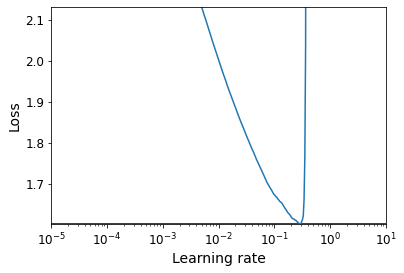

In [85]:
batch_size = 128
# run model savings raters and losses
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [86]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [87]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8397 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4116 - val_accuracy: 0.8588
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3868 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8719 - val_loss: 0.3766 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8775 - val_loss: 0.3739 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3635 - val_accuracy: 0.8708
Epoch 

## $\ell_1$ and $\ell_2$ regularization

You can use ℓ2 regularization to constrain a neural network’s connection weights, and/or ℓ1 regularization if you want a sparse model (with many weights equal to 0).

In [88]:
# l2 regularization with alpha = 0.01
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [89]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [90]:
# same code when we specified the desired layer and then loop over them
from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


# Avoiding Overfitting Through Regularization

## Dropout

The most popular regularization technique for deep neural networks is arguably dropout. It was proposed by G. E. Hinton in 2012 and further detailed in a paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks got a 1–2% accuracy boost simply by adding dropout. <br>

At every training step, every neuron (including the input neurons but excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter $p$ is called the dropout rate, and it is typically set at 10%-50%. Usually, 20-30% in recurrent neural networks and 40-50% in convolutional neural networks. 

After training, neurons don’t get dropped anymore. And that’s all (except for a technical detail we will discuss momentarily).

Imagine randomly 50% of employees are not working every day, then the remaining employees neeed to from new connections and revise their work finding new ways to do things. Dropping out is making companies and NN more resilient. 
![Neuron inner working g](images/image5.png)

In [91]:
tf.random.set_seed(42)
np.random.seed(42)
# 20% drop out rate
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5699 - accuracy: 0.8038 - val_loss: 0.3663 - val_accuracy: 0.8650
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4227 - accuracy: 0.8446 - val_loss: 0.3418 - val_accuracy: 0.8712
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3926 - accuracy: 0.8548 - val_loss: 0.3397 - val_accuracy: 0.8732
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3724 - accuracy: 0.8615 - val_loss: 0.3211 - val_accuracy: 0.8806
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3609 - accuracy: 0.8655 - val_loss: 0.3080 - val_accuracy: 0.8866
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3500 - accuracy: 0.8702 - val_loss: 0.3172 - val_accuracy: 0.8818
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3433 - accuracy: 0.8727 - val_loss: 0.3272 - val_accuracy:

In [92]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 702us/step - loss: 0.3278 - accuracy: 0.8830


[0.32775866985321045, 0.8830000162124634]

In [93]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 594us/step - loss: 0.1898 - accuracy: 0.9252


[0.18981856107711792, 0.9251999855041504]

## MC Dropout

In 2016, a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:
• First, the paper established a profound connection between dropout networks and approximate Bayesian inference, giving dropout a solid mathematical justification.
• Second, the authors introduced a powerful technique called MC Dropout, which
can boost the performance of any trained dropout model without having to
retrain it or even modify it at all, provides a much better measure of the model’s uncertainty, and is also amazingly simple to implement.

If this all sounds like a “one weird trick” advertisement, then take a look at the following
code. It is the full implementation of MC Dropout, boosting the dropout model
we trained earlier without retraining it:

In [94]:
tf.random.set_seed(42)
np.random.seed(42)

In [95]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

We just make 100 predictions over the test set, setting training=True to ensure that the Dropout layer is active, and stack the predictions. 

Since dropout is active, all the predictions will be different. 

Recall that predict() returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. 

We stack 100 such matrices, so y_probas is an array of shape [100, 10000, 10]. Once we average over the first dimension (axis=0), we get y_proba, an array of shape [10000, 10], like we would get
with a single prediction. 


That’s all! Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a
single prediction with dropout off. For example, let’s look at the model’s prediction for the first instance in the Fashion MNIST test set, with dropout off:

In [96]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.29, 0.  , 0.69]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot).
Should you trust it? Is there really so little room oom for doubt? Compare this with the
predictions made when dropout is activated:

In [97]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.62, 0.  , 0.35]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.8 , 0.  , 0.19]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.17, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.13, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.75, 0.  , 0.22]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.71, 0.  , 0.19]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.54, 0.  , 0.36]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.68, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.  , 0.55]],

       [[0.  , 0.01, 0.  , 0.  , 0.  , 0.2 , 0.  , 0.19, 0.  , 0.6 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.37, 0.  , 0.62]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.23, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.44, 0.  , 0.48]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1

This tells a very different story: apparently, when we activate dropout, the model is not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. Once we average over the first dimension, we get the following MC Dropout predictions:

In [98]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.37, 0.  , 0.58]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 78% confidence, which seems much more reasonable than 99%. Plus it’s useful to know exactly which other classes it thinks are likely. And you can also take a look at the standard deviation of the probability estimates:

In [99]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.24, 0.  , 0.26]],
      dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates: if you were building a risk-sensitive system (e.g., a medical or financial system), you should probably treat such an uncertain prediction with extreme caution. You definitely would not treat it like a 99% confident prediction. Moreover, the model’s accuracy got a small boost from 86.8:

In [100]:
y_pred = np.argmax(y_proba, axis=1)

In [101]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8844

If your model contains other layers that behave in a special way during training (such as BatchNormalization layers), then you should not force training mode like we just did. Instead, you should replace the Dropout layers with the following MCDropout
class:

In [102]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

In [104]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [105]:
mc_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)               

In [106]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [107]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [108]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.29, 0.  , 0.69]],
      dtype=float32)

Here, we just subclass the Dropout layer and override the call() method to force its training argument to True (see Chapter 12). If you are creating a model from scratch, it’s just a matter of using MCDropout rather than Dropout.

But if you have a model that was already trained using Dropout, you need to create a new model that’s identical to the existing model except that it replaces the Dropout layers with MCDrop out, then copy the existing model’s weights to your new model.

In short, MC Dropout is a fantastic technique that boosts dropout models and providesbetter uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

## Max norm

In [109]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [110]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4740 - accuracy: 0.8323 - val_loss: 0.3674 - val_accuracy: 0.8674
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3543 - accuracy: 0.8716 - val_loss: 0.3714 - val_accuracy: 0.8662


If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set.

It can also help to increase the dropout rate for large layers, and reduce it for small ones. 

Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

Cheat Sheet:

Initialization : He

Activation Function: ELE/SELU

Normalization: Batch/None

Regularization: Dropout

Optimizer: Adam

Learning Rate Schedule: None
    

1. If you can’t find a good learning rate (convergence was too slow, so you increased the training rate, and now convergence is fast but the network’s accuracy is suboptimal), then you can try adding a learning schedule such as exponential decay.

2. If your training set is a bit too small, you can implement data augmentation.

3. If you need a sparse model, you can add some ℓ1 regularization to the mix (and optionally zero out the tiny weights after training). 
4. If you need an even sparser model, you can try using FTRL instead of Adam optimization, along with ℓ1 regularization.
5. If you need a lightning-fast model at runtime, you may want to drop Batch Normalization, and possibly replace the ELU activation function with the leaky ReLU. H

![Neuron inner working g](images/Table_11_3.png)
![Neuron inner working g](images/Table_11_4.png)

* Don’t forget to normalize the input features!
* features! You should also try to reuse parts of a
pretrained neural network if you can find one that solves a similar problem
* If you need a low-latency model (one that performs lightning-fast predictions),
you may need to use fewer layers, fold the Batch Normalization layers into the
previous layers, and possibly use a faster activation function such as leaky ReLU
or just ReLU. Finally, you may want to
reduce the float precision from 32 bits to 16 or even 8 bits
* If you are building a risk-sensitive application, or inference latency is not very
important in your application, you can use MC Dropout to boost performance
and get more reliable probability estimates, along with uncertainty estimates.
